## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Тимофеев А. В. |
|---------|--------|
| Группа  | 7      |


In [1]:
from matplotlib import gridspec
from sklearn.datasets import make_classification
import pickle
import os
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import mnist 

# pick the seed for reproducability - change it to explore the effects of random variations
np.random.seed(0)
import random

## Подготовка датасетов
Объявим функции для анализа датасетов

In [2]:
def count_of_keys(df):
    unique = np.unique(df)
    counts = np.zeros(len(unique), dtype=np.int32)
    for v in df:
        counts[v] += 1
    return counts
def visualization_of_counts(df):
    counts = count_of_keys(df)
    plt.ylabel("Кол-во элементов в классе")
    plt.xlabel("Номер каждого класса")
    plt.bar(np.arange(len(counts)), counts)
    plt.xticks(np.arange(len(counts)), [i for i in range(len(counts))])
def analyze(labels, features, string :str):
    visualization_of_counts(labels)
    print("Данные для [{}]".format(string))
    print("Количество элементов в датасете : {}".format(len(labels)))
    print("Количество атрибутов в элементе : {}".format(len(features[0])))
    print("Минимальное значение атрибута   : {}".format(np.min(features)))
    print("Максимальное значение атрибута  : {}".format(np.max(features)))
    print()

## Подготовим датасеты и проанализируем их.

## MNIST

Датасет содержит черно-белые картинки, на которых изображены цифры. 

In [3]:
with open('mnist.pkl', 'rb') as mnist_pickle:
    MNIST = pickle.load(mnist_pickle)
print(MNIST.keys())

dict_keys(['Train'])


In [4]:
print(MNIST['Train'].keys())

dict_keys(['Labels', 'Features'])


Данные для [MNIST]
Количество элементов в датасете : 42000
Количество атрибутов в элементе : 784
Минимальное значение атрибута   : 0
Максимальное значение атрибута  : 255

Данные для [Обучающая выборка из MNIST]
Количество элементов в датасете : 33600
Количество атрибутов в элементе : 784
Минимальное значение атрибута   : 0.0
Максимальное значение атрибута  : 1.0

Данные для [Тестировочная выборка из MNIST]
Количество элементов в датасете : 8400
Количество атрибутов в элементе : 784
Минимальное значение атрибута   : 0.0
Максимальное значение атрибута  : 1.0



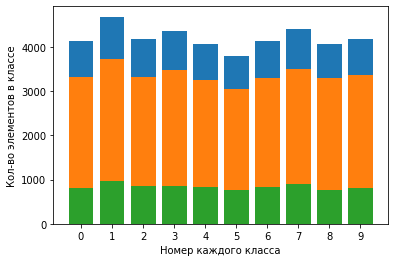

In [5]:
def conv_df(df):
    return np.array(df).astype(np.float32)/255

analyze(MNIST['Train']['Labels'], MNIST['Train']['Features'], "MNIST")

features = conv_df(MNIST['Train']['Features']) # переведем данные значения в числа с плавающей точкой от 0 до 1.
labels = MNIST['Train']['Labels']

mnist_train_x, mnist_test_x, mnist_train_y, mnist_test_y = train_test_split(features,labels,test_size=0.2)

analyze(mnist_train_y, mnist_train_x, "Обучающая выборка из MNIST")
analyze(mnist_test_y, mnist_test_x, "Тестировочная выборка из MNIST")

In [6]:
print(features)
print(labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[1 0 1 ... 7 6 9]


In [7]:
print("Размер обучающей выборки : {}".format(len(mnist_train_x)))
print("Размер тестовой выборки  : {}".format(len(mnist_test_x)))
print("Размер датасета MNIST    : {}".format(len(features)))

Размер обучающей выборки : 33600
Размер тестовой выборки  : 8400
Размер датасета MNIST    : 42000


### FashionMNIST

In [8]:
%cd fashion-mnist/utils
import mnist_reader
%cd ..
fashion_mnist_train_x_raw, fashion_mnist_train_y = mnist_reader.load_mnist('data/fashion', kind='train')
fashion_mnist_test_x_raw, fashion_mnist_test_y = mnist_reader.load_mnist('data/fashion', kind='t10k')
%cd ..

d:\education\education\AI\lab_perceptron-gearwheels\fashion-mnist\utils
d:\education\education\AI\lab_perceptron-gearwheels\fashion-mnist
d:\education\education\AI\lab_perceptron-gearwheels


Данные для [Обучающая выборка из Fashion MNIST]
Количество элементов в датасете : 60000
Количество атрибутов в элементе : 784
Минимальное значение атрибута   : 0
Максимальное значение атрибута  : 255

Данные для [Тестировочная выборка из Fashion MNIST]
Количество элементов в датасете : 10000
Количество атрибутов в элементе : 784
Минимальное значение атрибута   : 0
Максимальное значение атрибута  : 255



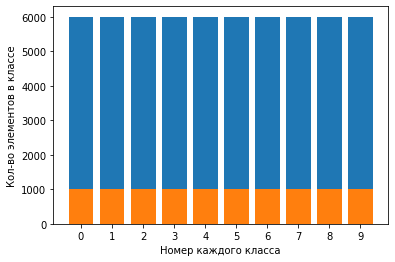

In [9]:
analyze(fashion_mnist_train_y, fashion_mnist_train_x_raw, "Обучающая выборка из Fashion MNIST")
analyze(fashion_mnist_test_y, fashion_mnist_test_x_raw, "Тестировочная выборка из Fashion MNIST")

Так как каждое значение картинки имеет значение от 0 до 255, переведем данные значения в числа с плавающей точкой от 0 до 1.

In [10]:
fashion_mnist_train_x = conv_df(fashion_mnist_train_x_raw)
fashion_mnist_test_x  = conv_df(fashion_mnist_test_x_raw)


## Обучение сети

## Слои нейронной сети и класс нейронной сети

In [11]:
import math
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x=x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db

class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)
    
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / self.p

class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy
    def copy(self):
        return Tanh()

class Net:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)

## Класс обучения нейросети 

Для промежуточного слоя будем использовать передаточную функцию `tanh`

Для функции потерь будем использовать `Cross Entropy Loss`




In [12]:
class Perceptron:
    def __init__(self, learning_rate=0.1,epochs=10, soft=Softmax(),act_func=Tanh(),
                layers=[5], loss_func=CrossEntropyLoss(),show_status=False):
        self.learning_rate=learning_rate
        self.epochs=epochs
        self.softmax=soft
        self.act_func=act_func
        self.layers=layers
        self.loss_function=loss_func
        self.show_status=show_status
        self.level=0
     
    def status_print(self, msg, level=-1):
        if level == -1:
            level = self.level
        print("  "*level + msg)
        
    def create_net(self, X, Y):
        self.net = Net()
        #узнаем ширину слоев нейросети
        layers_settings = self.layers.copy()
        layers_settings.insert(0, len(X[0]))
        layers_settings.append(len(np.unique(Y)))
        self.classes_count = layers_settings[-1]
        if self.show_status:
            self.status_print("Создание сети :")
            self.level += 1
            self.status_print("Количество скрытых слоев     : {}".format(len(layers_settings)-2))
            self.status_print("Количество входных нейронов  : {}".format(layers_settings[0]))
            self.status_print("Koличество выходных нейронов : {}".format(layers_settings[-1]))
            self.status_print("Широты скрытых слоев         : {}".format(self.layers))
            self.level -= 1
        #конфигурация нейросети слоями
        for i in range(len(layers_settings)-2):
            self.net.add(Linear(layers_settings[i], layers_settings[i+1]))
            self.net.add(self.act_func.copy())
        #добавляем выходной слой и softmax
        self.net.add(Linear(layers_settings[-2], layers_settings[-1]))
        self.net.add(self.softmax)
        return self    

    # функция обучения персептрона с графиками и результатами на тестовых и тренировочных данных
    def fit_and_plot_training_progress(self, X,Y,testX,testY):
        #создадим нейросеть
        training_accuracy_for_plot = []
        validation_accuracy_for_plot = []
        self.create_net(X,Y)
        #процесс обучения сети
        if self.show_status:
            self.level = 0
            self.status_print("Обучение сети:")
            self.level += 1
        print("|training|\t\t\t\t\t\t\t|validation|")
        for epoch in range(1, self.epochs + 1):
            self.train_epoch(X, Y)
            tmp_train_acc = (self.score(X,Y))[1]
            tmp_val_acc = (self.score(testX,testY))[1]
            training_accuracy_for_plot.append(tmp_train_acc)
            validation_accuracy_for_plot.append(tmp_val_acc)

            if self.show_status:
                #print("|training|\t\t\t\t\t\t\t|validation|")
                self.status_print("[epochs {} in {}] loss : {}, accuracy : {}\t\t [epochs {} in {}] loss : {}, accuracy : {}".format(
                    epoch, self.epochs, round(self.score(X,Y)[0], 5), round(self.score(X,Y)[1], 5), epoch, self.epochs, round(self.score(testX,testY)[0], 5), round(self.score(testX,testY)[1], 5)))
        plt.plot(range(1,self.epochs+1), training_accuracy_for_plot, 'g-')
        plt.plot(range(1,self.epochs+1), validation_accuracy_for_plot, 'h--')
        plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower center', ncol = 2)
        plt.xlim([0,self.epochs])
        plt.ylim([0,1])
        plt.show()
        return self

    def train_epoch(self, train_x, train_y, batch_size=4):
        net = self.net
        loss = self.loss_function
        lr = self.learning_rate
        for i in range(0,len(train_x),batch_size):
            xb = train_x[i:i+batch_size]
            yb = train_y[i:i+batch_size]

            p = net.forward(xb)
            l = loss.forward(p,yb)
            dp = loss.backward(l)
            dx = net.backward(dp)
            net.update(lr)  

    #вычисление вроятнсотей принадлжения каждому возможному классу
    def predict_prob(self, X):
        return self.net.forward(X)
    
    #выдаем наиболее вероятный класс (его номер)
    def predict(self, X):
        return np.argmax(self.predict_prob(X))
    
    def score(self, X,Y, calculate_confusion_matrix=False):
        p = self.net.forward(X)
        l = self.loss_function.forward(p,Y)
        pred = np.argmax(p,axis=1)
        acc = (pred==Y).mean()
        confusion_matrix=[]
        if calculate_confusion_matrix:
            confusion_matrix = np.zeros((self.classes_count, self.classes_count), dtype=np.int32)
            for prd, act in zip (pred, Y):
                confusion_matrix[prd][act] += 1
        return l,acc, confusion_matrix

### Тестирование на датасете Mnist
#### Однослойный перcептрон

Создание сети :
  Количество скрытых слоев     : 0
  Количество входных нейронов  : 784
  Koличество выходных нейронов : 10
  Широты скрытых слоев         : []
Обучение сети:
|training|							|validation|
  [epochs 1 in 10] loss : 0.31292, accuracy : 0.90938		 [epochs 1 in 10] loss : 0.34633, accuracy : 0.90726
  [epochs 2 in 10] loss : 0.2968, accuracy : 0.91455		 [epochs 2 in 10] loss : 0.34345, accuracy : 0.90833
  [epochs 3 in 10] loss : 0.28907, accuracy : 0.91756		 [epochs 3 in 10] loss : 0.34483, accuracy : 0.90988
  [epochs 4 in 10] loss : 0.28429, accuracy : 0.91952		 [epochs 4 in 10] loss : 0.34724, accuracy : 0.91107
  [epochs 5 in 10] loss : 0.28096, accuracy : 0.92042		 [epochs 5 in 10] loss : 0.34989, accuracy : 0.9125
  [epochs 6 in 10] loss : 0.27843, accuracy : 0.92104		 [epochs 6 in 10] loss : 0.35253, accuracy : 0.9125
  [epochs 7 in 10] loss : 0.27642, accuracy : 0.92164		 [epochs 7 in 10] loss : 0.35509, accuracy : 0.9119
  [epochs 8 in 10] loss : 0.27474, accuracy

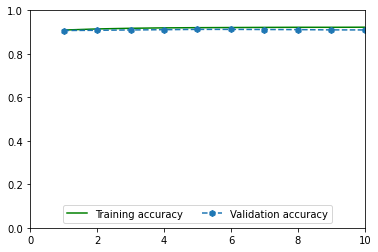

In [13]:
one_layered_perceptron = Perceptron(show_status=True, layers=[]).fit_and_plot_training_progress(mnist_train_x, mnist_train_y, mnist_test_x, mnist_test_y)

#### Двуслойный перcептрон

Создание сети :
  Количество скрытых слоев     : 1
  Количество входных нейронов  : 784
  Koличество выходных нейронов : 10
  Широты скрытых слоев         : [5]
Обучение сети:
|training|							|validation|
  [epochs 1 in 10] loss : 0.55676, accuracy : 0.84265		 [epochs 1 in 10] loss : 0.5714, accuracy : 0.83869
  [epochs 2 in 10] loss : 0.54515, accuracy : 0.83765		 [epochs 2 in 10] loss : 0.57043, accuracy : 0.83762
  [epochs 3 in 10] loss : 0.53354, accuracy : 0.8542		 [epochs 3 in 10] loss : 0.56849, accuracy : 0.85107
  [epochs 4 in 10] loss : 0.50332, accuracy : 0.85589		 [epochs 4 in 10] loss : 0.54126, accuracy : 0.8525
  [epochs 5 in 10] loss : 0.49214, accuracy : 0.86461		 [epochs 5 in 10] loss : 0.53251, accuracy : 0.85726
  [epochs 6 in 10] loss : 0.52245, accuracy : 0.84488		 [epochs 6 in 10] loss : 0.56641, accuracy : 0.84095
  [epochs 7 in 10] loss : 0.49136, accuracy : 0.86476		 [epochs 7 in 10] loss : 0.54019, accuracy : 0.85381
  [epochs 8 in 10] loss : 0.48529, accura

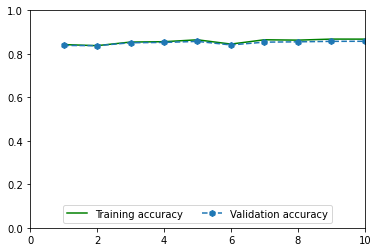

In [14]:
first_double_layered_perceptron = Perceptron(show_status=True).fit_and_plot_training_progress(mnist_train_x, mnist_train_y, mnist_test_x, mnist_test_y)

Создание сети :
  Количество скрытых слоев     : 1
  Количество входных нейронов  : 784
  Koличество выходных нейронов : 10
  Широты скрытых слоев         : [25]
Обучение сети:
|training|							|validation|
  [epochs 1 in 10] loss : 0.22673, accuracy : 0.93268		 [epochs 1 in 10] loss : 0.25739, accuracy : 0.92595
  [epochs 2 in 10] loss : 0.17961, accuracy : 0.94568		 [epochs 2 in 10] loss : 0.22379, accuracy : 0.93464
  [epochs 3 in 10] loss : 0.16419, accuracy : 0.94967		 [epochs 3 in 10] loss : 0.22329, accuracy : 0.93536
  [epochs 4 in 10] loss : 0.14097, accuracy : 0.95753		 [epochs 4 in 10] loss : 0.20862, accuracy : 0.94286
  [epochs 5 in 10] loss : 0.13217, accuracy : 0.9603		 [epochs 5 in 10] loss : 0.20779, accuracy : 0.94488
  [epochs 6 in 10] loss : 0.13932, accuracy : 0.95673		 [epochs 6 in 10] loss : 0.22723, accuracy : 0.93917
  [epochs 7 in 10] loss : 0.12088, accuracy : 0.96208		 [epochs 7 in 10] loss : 0.22046, accuracy : 0.94
  [epochs 8 in 10] loss : 0.15851, accura

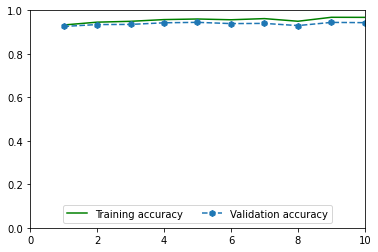

In [15]:
third_double_layered_perceptron = Perceptron(show_status=True, layers=[25]).fit_and_plot_training_progress(mnist_train_x, mnist_train_y, mnist_test_x, mnist_test_y)

Создание сети :
  Количество скрытых слоев     : 1
  Количество входных нейронов  : 784
  Koличество выходных нейронов : 10
  Широты скрытых слоев         : [100]
Обучение сети:
|training|							|validation|
  [epochs 1 in 10] loss : 0.15385, accuracy : 0.95467		 [epochs 1 in 10] loss : 0.19445, accuracy : 0.94655
  [epochs 2 in 10] loss : 0.11247, accuracy : 0.96446		 [epochs 2 in 10] loss : 0.163, accuracy : 0.95381
  [epochs 3 in 10] loss : 0.08711, accuracy : 0.97244		 [epochs 3 in 10] loss : 0.15947, accuracy : 0.95631
  [epochs 4 in 10] loss : 0.10165, accuracy : 0.96777		 [epochs 4 in 10] loss : 0.1947, accuracy : 0.95036
  [epochs 5 in 10] loss : 0.05358, accuracy : 0.98179		 [epochs 5 in 10] loss : 0.1569, accuracy : 0.96
  [epochs 6 in 10] loss : 0.05297, accuracy : 0.98173		 [epochs 6 in 10] loss : 0.16015, accuracy : 0.96143
  [epochs 7 in 10] loss : 0.04934, accuracy : 0.98289		 [epochs 7 in 10] loss : 0.16883, accuracy : 0.96167
  [epochs 8 in 10] loss : 0.04376, accuracy

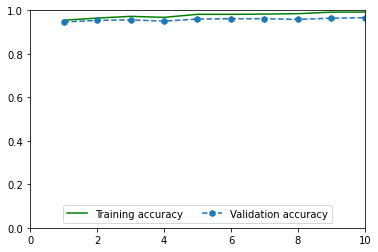

In [16]:
fourth_double_layered_perceptron = Perceptron(show_status=True, layers=[100]).fit_and_plot_training_progress(mnist_train_x, mnist_train_y, mnist_test_x, mnist_test_y)

#### Трехслойный перcептрон

Создание сети :
  Количество скрытых слоев     : 2
  Количество входных нейронов  : 784
  Koличество выходных нейронов : 10
  Широты скрытых слоев         : [5, 15]
Обучение сети:
|training|							|validation|
  [epochs 1 in 10] loss : 0.67998, accuracy : 0.79679		 [epochs 1 in 10] loss : 0.67895, accuracy : 0.79726
  [epochs 2 in 10] loss : 0.58714, accuracy : 0.8294		 [epochs 2 in 10] loss : 0.59867, accuracy : 0.82548
  [epochs 3 in 10] loss : 0.56376, accuracy : 0.83795		 [epochs 3 in 10] loss : 0.57889, accuracy : 0.83679
  [epochs 4 in 10] loss : 0.58627, accuracy : 0.8386		 [epochs 4 in 10] loss : 0.61028, accuracy : 0.83548
  [epochs 5 in 10] loss : 0.55582, accuracy : 0.84396		 [epochs 5 in 10] loss : 0.5872, accuracy : 0.83548
  [epochs 6 in 10] loss : 0.61541, accuracy : 0.83604		 [epochs 6 in 10] loss : 0.65006, accuracy : 0.82524
  [epochs 7 in 10] loss : 0.54591, accuracy : 0.84768		 [epochs 7 in 10] loss : 0.56888, accuracy : 0.84405
  [epochs 8 in 10] loss : 0.55507, ac

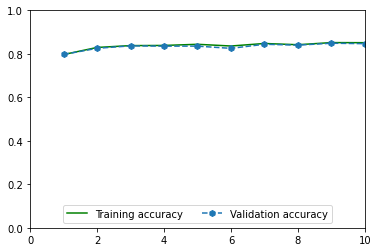

In [17]:
first_triple_layered_perceptron = Perceptron(show_status=True, layers=[5,15]).fit_and_plot_training_progress(mnist_train_x, mnist_train_y, mnist_test_x, mnist_test_y)

Создание сети :
  Количество скрытых слоев     : 2
  Количество входных нейронов  : 784
  Koличество выходных нейронов : 10
  Широты скрытых слоев         : [15, 10]
Обучение сети:
|training|							|validation|
  [epochs 1 in 10] loss : 0.33617, accuracy : 0.90625		 [epochs 1 in 10] loss : 0.35363, accuracy : 0.90274
  [epochs 2 in 10] loss : 0.32144, accuracy : 0.90884		 [epochs 2 in 10] loss : 0.34665, accuracy : 0.90476
  [epochs 3 in 10] loss : 0.28982, accuracy : 0.91818		 [epochs 3 in 10] loss : 0.32358, accuracy : 0.91179
  [epochs 4 in 10] loss : 0.2715, accuracy : 0.9214		 [epochs 4 in 10] loss : 0.31396, accuracy : 0.9125
  [epochs 5 in 10] loss : 0.2746, accuracy : 0.92396		 [epochs 5 in 10] loss : 0.31387, accuracy : 0.91381
  [epochs 6 in 10] loss : 0.256, accuracy : 0.9256		 [epochs 6 in 10] loss : 0.30081, accuracy : 0.91655
  [epochs 7 in 10] loss : 0.26182, accuracy : 0.92631		 [epochs 7 in 10] loss : 0.30384, accuracy : 0.91857
  [epochs 8 in 10] loss : 0.25213, accur

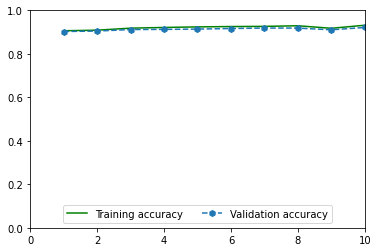

In [18]:
third_triple_layered_perceptron = Perceptron(show_status=True, layers=[15,10]).fit_and_plot_training_progress(mnist_train_x, mnist_train_y, mnist_test_x, mnist_test_y)

### Тестирование на датасете FashionMnist
#### Однослойный перcептрон

Создание сети :
  Количество скрытых слоев     : 0
  Количество входных нейронов  : 784
  Koличество выходных нейронов : 10
  Широты скрытых слоев         : []
Обучение сети:
|training|							|validation|
  [epochs 1 in 10] loss : 0.93704, accuracy : 0.79333		 [epochs 1 in 10] loss : 1.06076, accuracy : 0.7735
  [epochs 2 in 10] loss : 0.91264, accuracy : 0.80503		 [epochs 2 in 10] loss : 1.05009, accuracy : 0.7866
  [epochs 3 in 10] loss : 0.8731, accuracy : 0.81222		 [epochs 3 in 10] loss : 1.0226, accuracy : 0.7945
  [epochs 4 in 10] loss : 0.88366, accuracy : 0.81277		 [epochs 4 in 10] loss : 1.04423, accuracy : 0.7939
  [epochs 5 in 10] loss : 0.86853, accuracy : 0.815		 [epochs 5 in 10] loss : 1.03646, accuracy : 0.7958
  [epochs 6 in 10] loss : 0.81245, accuracy : 0.82255		 [epochs 6 in 10] loss : 0.98677, accuracy : 0.8016
  [epochs 7 in 10] loss : 0.78998, accuracy : 0.82595		 [epochs 7 in 10] loss : 0.97117, accuracy : 0.8036
  [epochs 8 in 10] loss : 0.75897, accuracy : 0.83

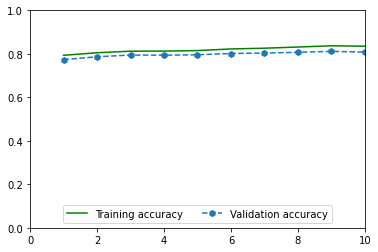

In [19]:
fmnist_null_perceptron = Perceptron(show_status=True, layers=[]).fit_and_plot_training_progress(fashion_mnist_train_x, fashion_mnist_train_y, fashion_mnist_test_x,fashion_mnist_test_y)

#### Двуслойный перcептрон

Создание сети :
  Количество скрытых слоев     : 1
  Количество входных нейронов  : 784
  Koличество выходных нейронов : 10
  Широты скрытых слоев         : [100]
Обучение сети:
|training|							|validation|
  [epochs 1 in 20] loss : 0.60132, accuracy : 0.80218		 [epochs 1 in 20] loss : 0.62128, accuracy : 0.7888
  [epochs 2 in 20] loss : 0.50957, accuracy : 0.8269		 [epochs 2 in 20] loss : 0.53418, accuracy : 0.8154
  [epochs 3 in 20] loss : 0.46978, accuracy : 0.83775		 [epochs 3 in 20] loss : 0.49764, accuracy : 0.8242
  [epochs 4 in 20] loss : 0.44578, accuracy : 0.84477		 [epochs 4 in 20] loss : 0.47613, accuracy : 0.8305
  [epochs 5 in 20] loss : 0.42879, accuracy : 0.8492		 [epochs 5 in 20] loss : 0.46117, accuracy : 0.8361
  [epochs 6 in 20] loss : 0.41568, accuracy : 0.8534		 [epochs 6 in 20] loss : 0.44979, accuracy : 0.8387
  [epochs 7 in 20] loss : 0.405, accuracy : 0.85707		 [epochs 7 in 20] loss : 0.44066, accuracy : 0.8418
  [epochs 8 in 20] loss : 0.396, accuracy : 0.85

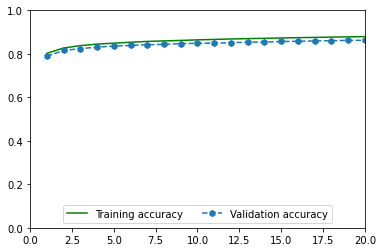

In [20]:
fmnist_second_perceptron = Perceptron(show_status=True, layers=[100], learning_rate=0.001, epochs=20)
fmnist_second_perceptron.fit_and_plot_training_progress(fashion_mnist_train_x, fashion_mnist_train_y, fashion_mnist_test_x,fashion_mnist_test_y)

Создание сети :
  Количество скрытых слоев     : 1
  Количество входных нейронов  : 784
  Koличество выходных нейронов : 10
  Широты скрытых слоев         : [13]
Обучение сети:
|training|							|validation|
  [epochs 1 in 10] loss : 0.43637, accuracy : 0.84683		 [epochs 1 in 10] loss : 0.47203, accuracy : 0.8332
  [epochs 2 in 10] loss : 0.40422, accuracy : 0.85787		 [epochs 2 in 10] loss : 0.44424, accuracy : 0.8441
  [epochs 3 in 10] loss : 0.38625, accuracy : 0.8646		 [epochs 3 in 10] loss : 0.43024, accuracy : 0.8516
  [epochs 4 in 10] loss : 0.3748, accuracy : 0.86807		 [epochs 4 in 10] loss : 0.42345, accuracy : 0.8545
  [epochs 5 in 10] loss : 0.36684, accuracy : 0.87082		 [epochs 5 in 10] loss : 0.41955, accuracy : 0.8544
  [epochs 6 in 10] loss : 0.36117, accuracy : 0.8732		 [epochs 6 in 10] loss : 0.41772, accuracy : 0.8555
  [epochs 7 in 10] loss : 0.35708, accuracy : 0.87443		 [epochs 7 in 10] loss : 0.4171, accuracy : 0.855
  [epochs 8 in 10] loss : 0.35452, accuracy : 0.8

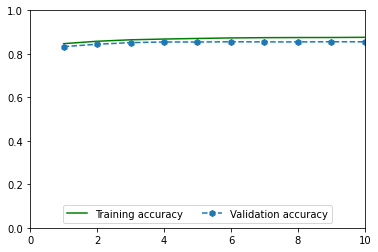

In [21]:
fmnist_first_perceptron = Perceptron(show_status=True, layers=[13], learning_rate=0.01).fit_and_plot_training_progress(fashion_mnist_train_x, fashion_mnist_train_y, fashion_mnist_test_x,fashion_mnist_test_y)

#### Трехслойный перcептрон

Создание сети :
  Количество скрытых слоев     : 2
  Количество входных нейронов  : 784
  Koличество выходных нейронов : 10
  Широты скрытых слоев         : [10, 15]
Обучение сети:
|training|							|validation|
  [epochs 1 in 20] loss : 0.72652, accuracy : 0.7701		 [epochs 1 in 20] loss : 0.74179, accuracy : 0.7622
  [epochs 2 in 20] loss : 0.56917, accuracy : 0.81053		 [epochs 2 in 20] loss : 0.59069, accuracy : 0.8012
  [epochs 3 in 20] loss : 0.50747, accuracy : 0.8269		 [epochs 3 in 20] loss : 0.5348, accuracy : 0.8133
  [epochs 4 in 20] loss : 0.4744, accuracy : 0.83598		 [epochs 4 in 20] loss : 0.50602, accuracy : 0.8225
  [epochs 5 in 20] loss : 0.45307, accuracy : 0.84197		 [epochs 5 in 20] loss : 0.4878, accuracy : 0.8278
  [epochs 6 in 20] loss : 0.43793, accuracy : 0.84648		 [epochs 6 in 20] loss : 0.47511, accuracy : 0.8318
  [epochs 7 in 20] loss : 0.4264, accuracy : 0.84952		 [epochs 7 in 20] loss : 0.46562, accuracy : 0.8335
  [epochs 8 in 20] loss : 0.41718, accuracy : 

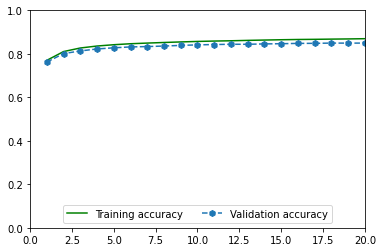

In [22]:
fmnist_second_perceptron = Perceptron(show_status=True, layers=[10,15], learning_rate=0.001, epochs=20)
fmnist_second_perceptron.fit_and_plot_training_progress(fashion_mnist_train_x, fashion_mnist_train_y, fashion_mnist_test_x,fashion_mnist_test_y)

Создание сети :
  Количество скрытых слоев     : 2
  Количество входных нейронов  : 784
  Koличество выходных нейронов : 10
  Широты скрытых слоев         : [10, 15]
Обучение сети:
|training|							|validation|
  [epochs 1 in 20] loss : 0.46494, accuracy : 0.83563		 [epochs 1 in 20] loss : 0.50107, accuracy : 0.82
  [epochs 2 in 20] loss : 0.41731, accuracy : 0.85192		 [epochs 2 in 20] loss : 0.46019, accuracy : 0.8356
  [epochs 3 in 20] loss : 0.39582, accuracy : 0.85905		 [epochs 3 in 20] loss : 0.44465, accuracy : 0.8408
  [epochs 4 in 20] loss : 0.38461, accuracy : 0.86238		 [epochs 4 in 20] loss : 0.44044, accuracy : 0.8413
  [epochs 5 in 20] loss : 0.37703, accuracy : 0.86532		 [epochs 5 in 20] loss : 0.43723, accuracy : 0.845
  [epochs 6 in 20] loss : 0.36891, accuracy : 0.8685		 [epochs 6 in 20] loss : 0.43304, accuracy : 0.8486
  [epochs 7 in 20] loss : 0.36614, accuracy : 0.87012		 [epochs 7 in 20] loss : 0.43209, accuracy : 0.8497
  [epochs 8 in 20] loss : 0.36541, accuracy 

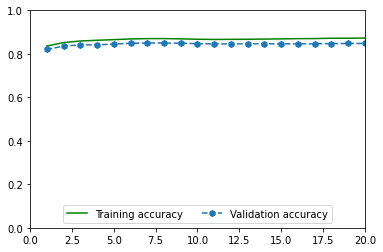

In [23]:
fmnist_second_perceptron = Perceptron(show_status=True, layers=[10,15], learning_rate=0.01, epochs=20)
fmnist_second_perceptron.fit_and_plot_training_progress(fashion_mnist_train_x, fashion_mnist_train_y, fashion_mnist_test_x,fashion_mnist_test_y)

Создание сети :
  Количество скрытых слоев     : 2
  Количество входных нейронов  : 784
  Koличество выходных нейронов : 10
  Широты скрытых слоев         : [10, 15]
Обучение сети:
|training|							|validation|
  [epochs 1 in 10] loss : 0.75355, accuracy : 0.76783		 [epochs 1 in 10] loss : 0.76906, accuracy : 0.762
  [epochs 2 in 10] loss : 0.57897, accuracy : 0.80955		 [epochs 2 in 10] loss : 0.6012, accuracy : 0.7988
  [epochs 3 in 10] loss : 0.51578, accuracy : 0.82593		 [epochs 3 in 10] loss : 0.54374, accuracy : 0.816
  [epochs 4 in 10] loss : 0.48309, accuracy : 0.83557		 [epochs 4 in 10] loss : 0.51531, accuracy : 0.8209
  [epochs 5 in 10] loss : 0.46177, accuracy : 0.84107		 [epochs 5 in 10] loss : 0.4971, accuracy : 0.8274
  [epochs 6 in 10] loss : 0.44639, accuracy : 0.8456		 [epochs 6 in 10] loss : 0.48417, accuracy : 0.8316
  [epochs 7 in 10] loss : 0.43463, accuracy : 0.84877		 [epochs 7 in 10] loss : 0.47451, accuracy : 0.8339
  [epochs 8 in 10] loss : 0.42528, accuracy :

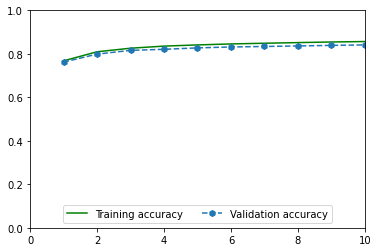

In [24]:
fmnist_second_perceptron = Perceptron(show_status=True, layers=[10,15], learning_rate=0.001, epochs=10)
fmnist_second_perceptron.fit_and_plot_training_progress(fashion_mnist_train_x, fashion_mnist_train_y, fashion_mnist_test_x,fashion_mnist_test_y)

Получим confusion matrix для двухслойного персептрона MNIST (с одним скрытым слоем 100 нейронов)

In [25]:
fourth_double_layered_confusion_matrix = fourth_double_layered_perceptron.score(mnist_test_x, mnist_test_y,calculate_confusion_matrix=True)[2]
print(fourth_double_layered_confusion_matrix)

[[799   0   6   1   1   3   3   2   3   5]
 [  0 950   3   2   5   0   0   2   3   1]
 [  1   4 826   7   1   1   1   5   0   1]
 [  1   0   1 800   0   3   0   2   3   3]
 [  1   0   0   2 791   2   2   3   2  13]
 [  2   0   1  25   1 739   3   2  14   8]
 [  3   0   0   1   4   5 828   0   4   1]
 [  1   5  12   4   2   0   0 878   2  10]
 [  5   2   9  15   4   3   4   2 736   0]
 [  0   0   2   6  18   0   0   3   1 770]]


Получим confusion matrix для трехслойного персептрона FashionMNIST (с двумя скрытыми слоями 10 и 15 нейронов)

In [26]:
fmnist_second_perceptron_confusion_matrix = fmnist_second_perceptron.score(mnist_test_x, mnist_test_y,calculate_confusion_matrix=True)[2]
print(fmnist_second_perceptron_confusion_matrix)

[[  2  51  79 155 206  60   3 185 187 159]
 [  7   6  33 144  66 110  21  21 157 168]
 [198   0   8  10  75  45  13  50   3  52]
 [ 75 214 299 242  71 175 348 180 230 169]
 [269   2 105  62  21  78 135   3  53  50]
 [224   9 158  81 158 221 150  40  44  48]
 [  0   0  29  15  38  32   1 397  44  92]
 [  1 181  63 112  85   7  35  10  17  43]
 [ 36   0  81  16 106  19 134  10  17  21]
 [  1 498   5  26   1   9   1   3  16  10]]


Получим confusion matrix для двухслойного персептрона MNIST (с одним скрытым слоем 5 нейронов)

In [28]:
first_double_layered_perceptron_confusion_matrix = first_double_layered_perceptron.score(mnist_test_x, mnist_test_y,calculate_confusion_matrix=True)[2]
print(first_double_layered_perceptron_confusion_matrix)

[[744   0  18   6   0  45   9  11  11   9]
 [  0 920  27  22   1   0   2  13  21   1]
 [  5   6 660  42   1   2   1  13   5   0]
 [  1   2   1 648   0  34   0   0   6   3]
 [  4   3   7   3 754   7  10  13   6  70]
 [  5   3   1  91   2 574   6   1  35  21]
 [ 46   8  54  10  31  33 795   1  28   4]
 [  0   4  35  20   3   2   0 804   1  30]
 [  8  14  51   8   9  52  17   2 645  13]
 [  0   1   6  13  26   7   1  41  10 661]]


## Вывод

В данной лабораторной работе я реализовал собственную нейросеть, основанную на методе обучения с учителем. Веса в данной модели регулируются задачей минимизации функции ошибки методом градиентного спуска.

Далее я решил задачу классификации для датасетов MNIST, FashionMNIST с помощью 1, 2 и 3-слойного персептрона. Закономерности которые удалось установить в ходе решения:
* достаточно одного скрытого слоя на 100 нейронов, чтобы решить задачу классификации MNIST с точностью 96%, но это требует в 2 - 3 раза больше времени на обучение нейросети чем обучение обычной нейросети без скрытого слоя, у которой точностью 90%
* задача классификации FashionMNIST решается с точностью 85% при скорости обучения 0.001 и 20 эпохах, а для решения задача классификации MNIST достаточно скорости обучения 0.1 и 10 эпох Fashion
* Нейросеть с двумя скрытыми слоями, в каждом из которых больше 10 нейронов, обучается быстрее чем нейросеть с одним скрытым слоем на 100 нейронов и проигрывает в точности на пару процентов на датасете MNIST и почти не проигрывает на датасете FashionMNIST

Максимальная точность классификации датасетов нейросетью составила 96% для MNIST и 85% для FashionMNIST соответственно. Данные результаты удовлетворяют условиям поставленным в лабораторной работе.

